# Advanced Measure Region Properties plugin

Create a plugin that measures region properties and display results as a table. Use QtPy to implement this plugin.

1) Load data
2) Segment cells
3) Measure properties
4) Display measured properties in a table
5) Optional: Show a UMAP plot of the measured properties

## Primer

Measuring properties of cells is an important task to identify sub-populations of cells.

There are a number of QtPy widgets that will come in handy. 

In [1]:
from skimage import data
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import numpy as np

import napari
from magicgui import magicgui

from napari.layers import Image
from napari.types import LabelsData
import pathlib

## Load sample data

In [2]:
IMAGE2D = data.cells3d()[30,1]

## Define plugin functions

In [3]:
def segment_cells(img):
    from cellpose import models
    
    model = models.CellposeModel(gpu=True)
    img = img_as_float(img)
    mask, __, __ = model.eval(img)
    
    return mask

def get_properties(mask, img):
    from skimage.measure import regionprops 
    
    return regionprops(mask, img)
    
def save_props_table(props, mask, properties, path):
    import pandas as pd

    prop_list = []
    for index in range(1, mask.max()):
        prop_list.append([index] + [props[index][prop_name] for prop_name in properties])
    prop_array = np.asarray(prop_list)
    df = pd.DataFrame(prop_array, columns=['CellID'] + properties)
    df.to_csv(path)

## QtPy Implementation

napari.Viewer: napari


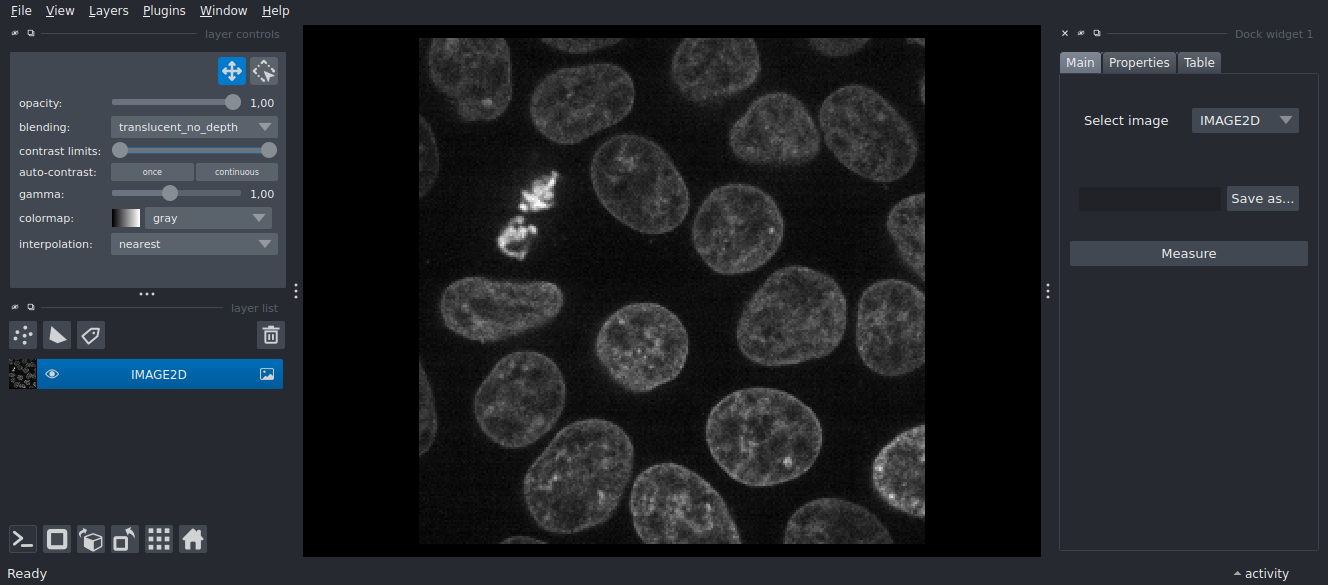

In [5]:
from qtpy.QtWidgets import (QWidget, QTabWidget, QTableWidget, QLabel,
                            QAbstractItemView, QVBoxLayout, QHBoxLayout,
                            QCheckBox, QScrollArea, QFileDialog, QPushButton,
                            QLineEdit, QComboBox, QTableWidgetItem)

class MeasureRegionprops(QWidget):
    def __init__(self, napari_viewer='napari.viewer.Viewer'):
        super().__init__()
        self.viewer = napari_viewer
        print(self.viewer)
        self.setLayout(QVBoxLayout())

        # Create tab widget
        main_tab = QTabWidget()
        main_tab.setLayout(QVBoxLayout())
        
        # Create main widget for user settings
        main_widget = QWidget()
        main_widget.setLayout(QVBoxLayout())
        main_widget.setFixedHeight(200)

        # Select image layer
        layer_widget = QWidget()
        layer_widget.setLayout(QHBoxLayout())
        layer_label = QLabel('Select image')
        self._image_layers = QComboBox(self)        
        layer_widget.layout().addWidget(layer_label)
        layer_widget.layout().addWidget(self._image_layers)
        main_widget.layout().addWidget(layer_widget)

        # Select path to save results
        path_widget = QWidget()
        path_widget.setLayout(QHBoxLayout())
        self.path_line_edit = QLineEdit('')
        path_btn = QPushButton('Save as...')
        path_btn.clicked.connect(self._select_path)        
        path_widget.layout().addWidget(self.path_line_edit)
        path_widget.layout().addWidget(path_btn)
        main_widget.layout().addWidget(path_widget)
        
        # Run plugin
        run_btn = QPushButton('Measure')
        run_btn.clicked.connect(self._measure_regionprops)
        main_widget.layout().addWidget(run_btn)
        
        main_tab.addTab(main_widget, 'Main')
        
        # List all properties that can be measured
        prop_widget = QWidget()
        prop_widget.setLayout(QVBoxLayout())
        all_props = self._get_all_region_properties()
        self.widget_dict = dict()
        for prop in all_props:
            widget_ = QWidget()
            widget_.setLayout(QHBoxLayout())
            self.widget_dict[prop] = QCheckBox()
            self.widget_dict[prop].setChecked(True)
            qlabel_ = QLabel(prop)
            widget_.layout().addWidget(qlabel_)
            widget_.layout().addWidget(self.widget_dict[prop])
            prop_widget.layout().addWidget(widget_)

        # Make the widget scrollable
        scroll = QScrollArea()
        scroll.setWidget(prop_widget)
        main_tab.addTab(scroll, 'Properties')

        # Create widget to display results in a table
        self.table = QTableWidget(self)
        self.table.setEditTriggers(QAbstractItemView.NoEditTriggers)
        
        # Widget to select region properties from drop down menu to add to list that extends
        main_tab.addTab(self.table, 'Table')
        self.layout().addWidget(main_tab)

        self._update_combo_box()

    def _select_path(self):
        self.path = QFileDialog().getOpenFileName(self, "Save as...", ".", "CSV file (*.csv)")[0]
        self.path_line_edit.setText(self.path)

    def _measure_regionprops(self):
        all_props = self._get_all_region_properties()

        properties = []
        for prop in all_props:
            if self.widget_dict[prop].isChecked():
                properties.append(prop)
                
        img = self._get_selected_image_layer()
        
        mask = segment_cells(img.data)
        self.viewer.add_labels(mask)
        props = get_properties(mask, img.data)
        save_props_table(props, mask, properties, self.path)    

        props_list, props_names = self._make_props_table(props, mask, properties)

        self._update_table(props_list, props_names)

    def _update_combo_box(self):
        for layer_name in [self._image_layers.itemText(i) for i in range(self._image_layers.count())]:
            layer_name_index = self._image_layers.findText(layer_name)
            self._image_layers.removeItem(layer_name_index)

        for layer in [l for l in self.viewer.layers if isinstance(l, napari.layers.Image)]:
            if layer.name not in [self._image_layers.itemText(i) for i in range(self._image_layers.count())]:
                self._image_layers.addItem(layer.name)

    def _get_selected_image_layer(self):
        return self.viewer.layers[self._image_layers.currentText()]
    
    def _get_all_region_properties(self):
        from skimage.measure import regionprops, label
        image_ = np.random.rand(10,10)
        mask_ = label(image_ > 0.5)
        props = regionprops(mask_, image_)

        all_props = []
        for prop in props[0]:
            if isinstance(props[0][prop], int) or isinstance(props[0][prop], float):
                all_props.append(prop)

        return all_props

    def _make_props_table(self, props, mask, properties):
        prop_list = []
        for index in range(1, mask.max()):
            prop_list.append([index] + [props[index][prop_name] for prop_name in properties])

        return prop_list, ['CellID'] + properties

    def _update_table(self, props_list, props_names):
        self.table.setColumnCount(len(props_names))

        for row, props in enumerate(props_list):
            self.table.insertRow(self.table.rowCount())
            for col, prop in enumerate(props):
                self.table.setItem(self.table.rowCount()-1, col, QTableWidgetItem(str(prop)))
        self.table.setHorizontalHeaderLabels(props_names)

viewer = napari.view_image(IMAGE2D)
widget = MeasureRegionprops(napari_viewer=viewer)
viewer.window.add_dock_widget(widget)
napari.utils.nbscreenshot(viewer)